<a href="https://colab.research.google.com/github/rymarinelli/Python/blob/master/Police_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from time import sleep
import time 
from threading import *

In [2]:
!pip install pyspark 
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType

In [3]:
import plotly.express as px
import pyspark.sql.functions as f
from pyspark.sql.functions import desc
from pyspark.sql.functions import col,concat, lit

In [4]:
file = "https://raw.githubusercontent.com/rymarinelli/Python/master/Tidy%20Tuesday/Data/allegations_202007271729.csv"

In [5]:
conf = SparkConf().setMaster("local").setAppName("Police_Analysis")
conf.set("spark.scheduler.mode", "FAIR")
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [6]:
def set_spark_context(app_name=None):
    conf = SparkConf().\
            setAppName(app_name).\
            set('spark.hadoop.mapreduce.output.fileoutputformat.compress', 'false').\
            set('spark.sql.parquet.compression.codec','uncompressed').\
            set('spark.scheduler.mode','FAIR') # need to set this on the sparkContext
    sc = SparkContext(conf=conf)
    try:
        sc._jvm.org.apache.hadoop.hive.conf.HiveConf()
        sqlCtx = sqlContext = HiveContext(sc)
    except py4j.protocol.Py4JError:
        sqlCtx = sqlContext = SQLContext(sc)
    return sc, sqlContext

In [7]:
df = pd.read_csv(file, error_bad_lines=False)
df.to_csv("data.csv")


In [8]:
df = sqlContext.read.csv("/content/data.csv", header= True)

In [9]:
# month and year 
# rank_now
# rank_incident
# complainant_ethnicity
# complainant_gender
# allegation 
# board_disposition

# Questions 
# Are people getting promoted that have violated policy?
# Are there habitual offenders? 
# How does the board respond?
# Is the board more or less likely to substanitate a compliant based on gender or ethnicity of person giving the compliant. 
# How do rates of compliants vary over time? 



In [10]:
df = df.select("unique_mos_id", "rank_now","rank_incident","complainant_ethnicity","complainant_age_incident","complainant_gender","allegation","board_disposition")

In [11]:
habit = df.groupBy("unique_mos_id","allegation").count()
habit.agg({'count':'max'}).show()
habit.agg({'count':'mean'}).show()

+----------+
|max(count)|
+----------+
|        15|
+----------+

+------------------+
|        avg(count)|
+------------------+
|1.4538243626062324|
+------------------+



In [12]:
habit = habit.filter(habit[2] > 4)


In [13]:
df = habit.toPandas()
fig = px.box(df, y="count")
fig.show()

In [14]:
df.median()

unique_mos_id    19602.0
count                5.5
dtype: float64

The average of the total data is around 1.5. When you remove officers that have 4 or less, then the extremes become more pronounced. When removing the subset of officers with fewer compliants, the median becomes 5.5. 

In [15]:
habit = habit.filter(habit[2] > 10)
df = habit.toPandas()
fig = px.box(df, y="count")
fig.show()

(13, 3)

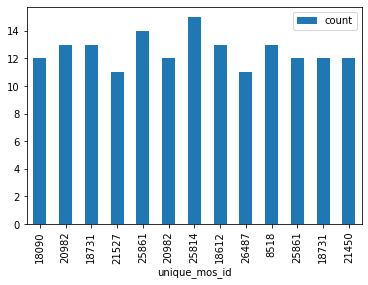

In [16]:
df.plot.bar(x = 'unique_mos_id', y = 'count' )
df.shape

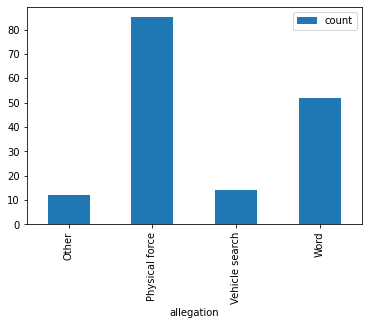

In [17]:
offencies = df.groupby('allegation').agg("sum")
offencies.plot.bar()

This group constitues the officers that have the most complaints issued against them. They also appear to be the most violent as physical force complaints vastly outnumber the others. 

In [18]:
id = df['unique_mos_id']
id = id.to_list()

In [19]:
df = sqlContext.read.csv("/content/data.csv", header= True)
df.select("unique_mos_id", "rank_now","rank_incident","complainant_ethnicity","complainant_age_incident","complainant_gender","allegation","board_disposition")

DataFrame[unique_mos_id: string, rank_now: string, rank_incident: string, complainant_ethnicity: string, complainant_age_incident: string, complainant_gender: string, allegation: string, board_disposition: string]

Filtering data to only officers that have the most complaints against them

In [20]:
problem = df.filter(f.col("unique_mos_id").isin(id))

In [21]:
 df_1 = problem.select("year_received","rank_incident","unique_mos_id")

 

In [22]:
minTest = df_1.sort("year_received", ascending = False)
maxTest = df_1.sort("year_received", ascending = True)


In [23]:
#df.filter(f.col("unique_mos_id").isin("25861")).show()
table_list = list()
id_list = list()
year_list = []
rank_list = []

for i in id:
 table = df.filter(f.col("unique_mos_id").isin(i))
 table = table.select("unique_mos_id", "rank_incident","year_received")
 table = table.limit(1).collect()
 id_list.append(table[0][0])
 rank_list.append(table[0][1])
 year_list.append(table[0][2])
 

In [24]:
id_test = pd.DataFrame(id_list)
year_test = pd.DataFrame(year_list)
rank_test = pd.DataFrame(rank_list)


In [25]:
table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
table = sqlContext.createDataFrame(table)
table = table.withColumnRenamed("0","ID")
table = table.withColumnRenamed("1", "Year")
table = table.withColumnRenamed("2","Rank")
table.groupBy('ID',"Year","Rank").count().show()

+-----+----+--------------+-----+
|   ID|Year|          Rank|count|
+-----+----+--------------+-----+
|25861|2005|Police Officer|    2|
|21450|2003|Police Officer|    1|
|18090|2017|      Sergeant|    1|
|21527|1999|Police Officer|    1|
|26487|2010|     Detective|    1|
|20982|2005|Police Officer|    2|
|18731|2003|      Sergeant|    2|
|18612|2004|Police Officer|    1|
|25814|2005|    Lieutenant|    1|
| 8518|1999|Police Officer|    1|
+-----+----+--------------+-----+



Overall for when people make their first complaint

In [26]:
table_list = list()
id_list = list()
year_list = []
rank_list = []
maxTest = df.sort("year_received", ascending = True)
count = 0

id = df.select('unique_mos_id').distinct().collect()

filter_id = []
for i in id:
 filter_id.append(i[0])
maxTest = maxTest.select("unique_mos_id", "rank_incident","year_received")

In [27]:

filter_id_One = filter_id[:400]
filter_id_Two = filter_id[400:800]
filter_id_Three = filter_id[800:1200] 
filter_id_Four = filter_id[1200:1600] 
filter_id_Five = filter_id[1600:2000]
filter_id_Sixth = filter_id[2000:2400]
filter_id_Seventh = filter_id[2400:2800]
filter_id_Eighth = filter_id[2800:3200]
filter_id_Nineth = filter_id[3200:3600]
filter_id_Tenth = filter_id[3600:]

In [28]:
class FirstSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_One :
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank") 
    table = table.groupBy('ID',"Year","Rank").count()   
    table.write.parquet("FirstSegment.parquet")
        
 
class SecondSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Two:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)  
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank")
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("SecondSegment.parquet")
 
class ThirdSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Three:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3) 
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank")
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("ThirdSegment.parquet")
        
 
class FourthSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Four:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3) 
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank")
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("FourthSegment.parquet")
 
class FifthSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Five:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)  
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)  
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank") 
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("FifthSegment.parquet")
 
class SixthSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Sixth:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3) 
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank")
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("SixthSegment.parquet")
 
class SeventhSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Seventh :
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank") 
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("SevethSegment.parquet")      
   
class EighthSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Eighth:
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank") 
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("EigthSegment.parquet")   
 
class NinethSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Nineth :
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("NinethSegment.parquet")        
 
class TenthSegment(Thread):
  def run(self):
    count = 0
    for i in filter_id_Tenth :
        table = maxTest.filter(f.col("unique_mos_id").isin(i))
        table = table.limit(1).collect()
 
        id_list.append(table[0][0])
        rank_list.append(table[0][1])
        year_list.append(table[0][2])
        count = count + 1
        sleep(.3)
    id_test = pd.DataFrame(id_list)
    year_test = pd.DataFrame(year_list)
    rank_test = pd.DataFrame(rank_list)   
    table = pd.concat([id_test, year_test, rank_test], axis=1, ignore_index=True)
    table = sqlContext.createDataFrame(table)
    table = table.withColumnRenamed("0","ID")
    table = table.withColumnRenamed("1", "Year")
    table = table.withColumnRenamed("2","Rank") 
    table = table.groupBy('ID',"Year","Rank").count()  
    table.write.parquet("TenthSegment.parquet")       
 
first = FirstSegment()
second = SecondSegment()
third = ThirdSegment()
fourth = FourthSegment()
fifth = FifthSegment()
sixth = SixthSegment()
seventh = SeventhSegment()
eighth = EighthSegment()
nineth = NinethSegment()
tenth = TenthSegment()

 
start_time = time.time() 
first.start()
sleep(0.3)
second.start() 
sleep(0.3)
third.start()
sleep(0.3)
fourth.start()
sleep(0.3)
fifth.start()
sleep(0.3)
sixth.start()
sleep(0.3)
seventh.start()
sleep(0.3)
eighth.start()
sleep(0.3)
nineth.start()
sleep(0.3)
tenth.start()

first.join()
second.join()
third.join()
fourth.join()
fifth.join()
sixth.join()
seventh.join()
eighth.join()
nineth.join()
tenth.join()


print("My program took", time.time() - start_time, "to run") 


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-28-b711cc16b8c8>", line 22, in run
    table.write.parquet("FirstSegment.parquet")
  File "/usr/local/lib/python3.6/dist-packages/pyspark/sql/readwriter.py", line 936, in parquet
    self._jwrite.parquet(path)
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 1305, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/sql/utils.py", line 137, in deco
    raise_from(converted)
  File "<string>", line 3, in raise_from
pyspark.sql.utils.AnalysisException: path file:/content/FirstSegment.parquet already exists.;

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-28-b711cc16b8c8>", line 46, in run
  

My program took 547.4528217315674 to run


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-28-b711cc16b8c8>", line 206, in run
    table = table.groupBy('ID',"Year","Rank").count()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/sql/group.py", line 33, in _api
    jdf = getattr(self._jgd, name)()
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 1305, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/sql/utils.py", line 137, in deco
    raise_from(converted)
  File "<string>", line 3, in raise_from
pyspark.sql.utils.AnalysisException: cannot resolve '`Rank`' given input columns: [2, ID, Year];;
'Aggregate [ID#12629, Year#12637, 'Rank], [ID#12629, Year#12637, 'Rank, count(1) AS count#12647L]
+- Project [ID#12629, 1#12620 AS Year#12637, 2#12621]
   +- Project [0#12619 AS ID#12629, 1#12620, 2#12621

In [48]:
 files = ["FirstSegment.parquet", "SecondSegment.parquet", "ThirdSegment.parquet",
               "FourthSegment.parquet", "FifthSegment.parquet", "SixthSegment.parquet",
               "SevethSegment.parquet", "EigthSegment.parquet", "NinethSegment.parquet",
                "TenthSegment.parquet"]

df = sqlContext.read.parquet("/content/" + files[0])

for i in files[1:]:
  df.union(sqlContext.read.parquet("/content/" + i))



+-----+----+--------------+-----+
|   ID|Year|          Rank|count|
+-----+----+--------------+-----+
|32506|2002|Police Officer|    1|
| 6586|2014|Police Officer|    1|
|16236|2003|Police Officer|    1|
|20864|2004|Police Officer|    1|
|18616|1996|      Sergeant|    1|
|20500|1991|Police Officer|    1|
|20256|2013|Police Officer|    1|
|19825|2014|Police Officer|    1|
| 4543|2007|Police Officer|    1|
| 3070|2014|Police Officer|    1|
|26017|2013|Police Officer|    1|
|20861|2015|      Sergeant|    1|
|14265|2008|Police Officer|    1|
| 6852|2016|Police Officer|    1|
|21042|2013|Police Officer|    1|
|35930|2014|Police Officer|    1|
|16877|2008|Police Officer|    1|
|26882|2004|      Sergeant|    1|
| 3742|2008|Police Officer|    1|
|17045|1998|Police Officer|    1|
+-----+----+--------------+-----+
only showing top 20 rows



AttributeError: ignored

In [52]:
df.write.parquet("firstProblem.parquet")

AnalysisException: ignored